In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset, setting the first column ('Date') as the index and parsing dates
df = pd.read_csv(r"C:\Users\ratnakar\Downloads\AAPL.csv", index_col=0, parse_dates=True)

# Check the initial structure and info
print("Initial Info:")
print(df.info())

# View first few rows
print("\nFirst few rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Forward fill missing values using ffill() method
df.ffill(inplace=True)

# Double-check missing values after fill
print("\nMissing Values After Fill:")
print(df.isnull().sum())

# Feature Selection: We will only use 'Adj Close' for prediction
data = df[['Adj Close']].copy()
print("\nSelected Feature (Adj Close):")
print(data.head())


Initial Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9823 entries, 1980-12-12 to 2019-11-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9822 non-null   float64
 1   High       9822 non-null   float64
 2   Low        9822 non-null   float64
 3   Close      9822 non-null   float64
 4   Adj Close  9822 non-null   float64
 5   Volume     9822 non-null   float64
dtypes: float64(6)
memory usage: 537.2 KB
None

First few rows:
                Open      High       Low     Close  Adj Close       Volume
Date                                                                      
1980-12-12  0.513393  0.515625  0.513393  0.513393   0.407747  117258400.0
1980-12-15  0.488839  0.488839  0.486607  0.486607   0.386473   43971200.0
1980-12-16  0.453125  0.453125  0.450893  0.450893   0.358108   26432000.0
1980-12-17  0.462054  0.464286  0.462054  0.462054   0.366972   21610400.0
1980-12-18  0.475446  0.4776

In [5]:
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the adjusted close data
scaled_data = scaler.fit_transform(data)

# Just to check the scaled data
print(f"Scaled data shape: {scaled_data.shape}")
print(f"First 5 scaled values: {scaled_data[:5]}")

Scaled data shape: (9823, 1)
First 5 scaled values: [[0.00094304]
 [0.00086335]
 [0.00075709]
 [0.00079029]
 [0.00083014]]


In [7]:
# Function to create time-series sequences
def create_sequences(data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - window_size - prediction_horizon + 1):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size + prediction_horizon - 1])
    return np.array(X), np.array(y)

# Example: Create 1-day ahead sequences with a 60-day window
window_size = 60  # Look back over the last 60 days
prediction_horizon = 1  # Predict the next day's price

X, y = create_sequences(scaled_data, window_size, prediction_horizon)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (9763, 60, 1), y shape: (9763, 1)


In [9]:
# Summary statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9823.000000,9823.000000,9823.000000,9823.000000,9823.000000,9.823000e+03
mean,30.347013,30.637560,30.045285,30.349896,28.361182,8.619865e+07
std,53.441147,53.906480,52.981805,53.462400,51.601736,8.623115e+07
min,0.198661,0.198661,0.196429,0.196429,0.156008,3.472000e+05
25%,1.062500,1.085000,1.043214,1.066696,0.913734,3.318000e+07
50%,1.709286,1.741429,1.671429,1.712857,1.452015,5.798800e+07
75%,30.387856,30.547143,29.865001,30.232143,26.305014,1.076306e+08
max,267.899994,268.000000,265.390015,267.100006,267.100006,1.855410e+09


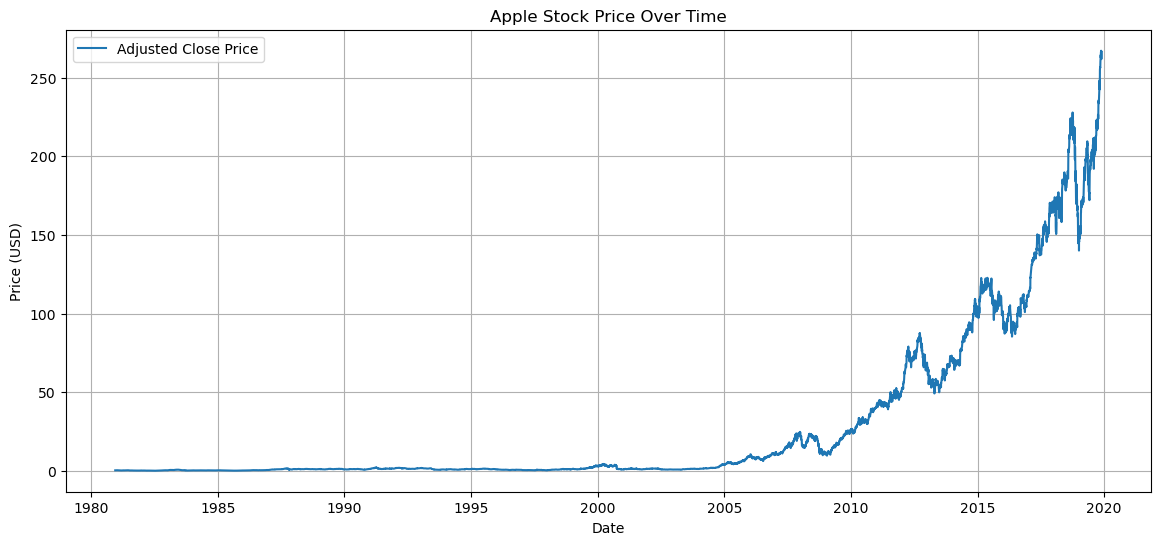

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(df['Adj Close'], label='Adjusted Close Price')
plt.title('Apple Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

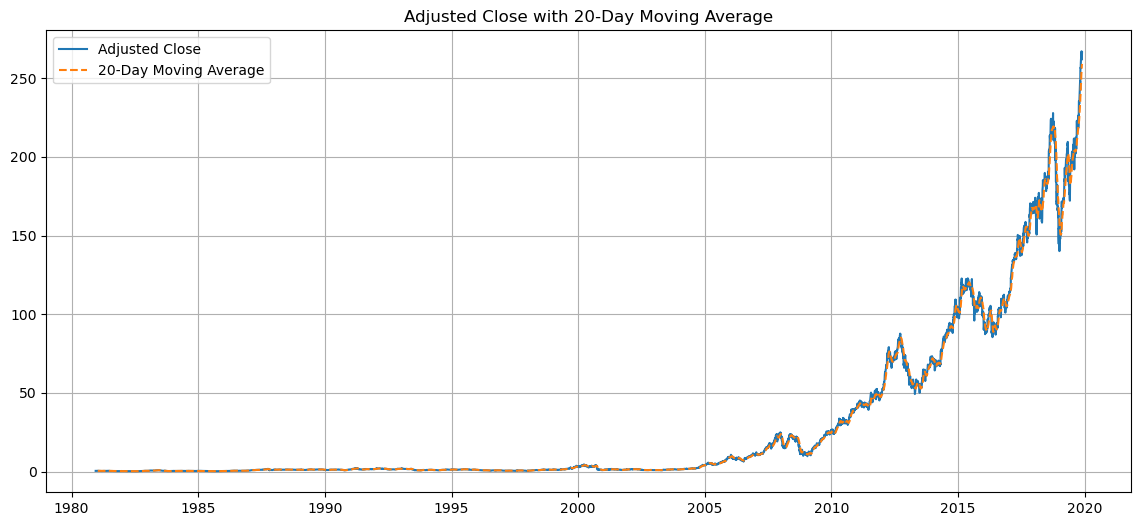

In [13]:
# 20-day rolling average
df['20_day_ma'] = df['Adj Close'].rolling(window=20).mean()

# Plot rolling average
plt.figure(figsize=(14,6))
plt.plot(df['Adj Close'], label='Adjusted Close')
plt.plot(df['20_day_ma'], label='20-Day Moving Average', linestyle='--')
plt.title('Adjusted Close with 20-Day Moving Average')
plt.legend()
plt.grid(True)
plt.show()

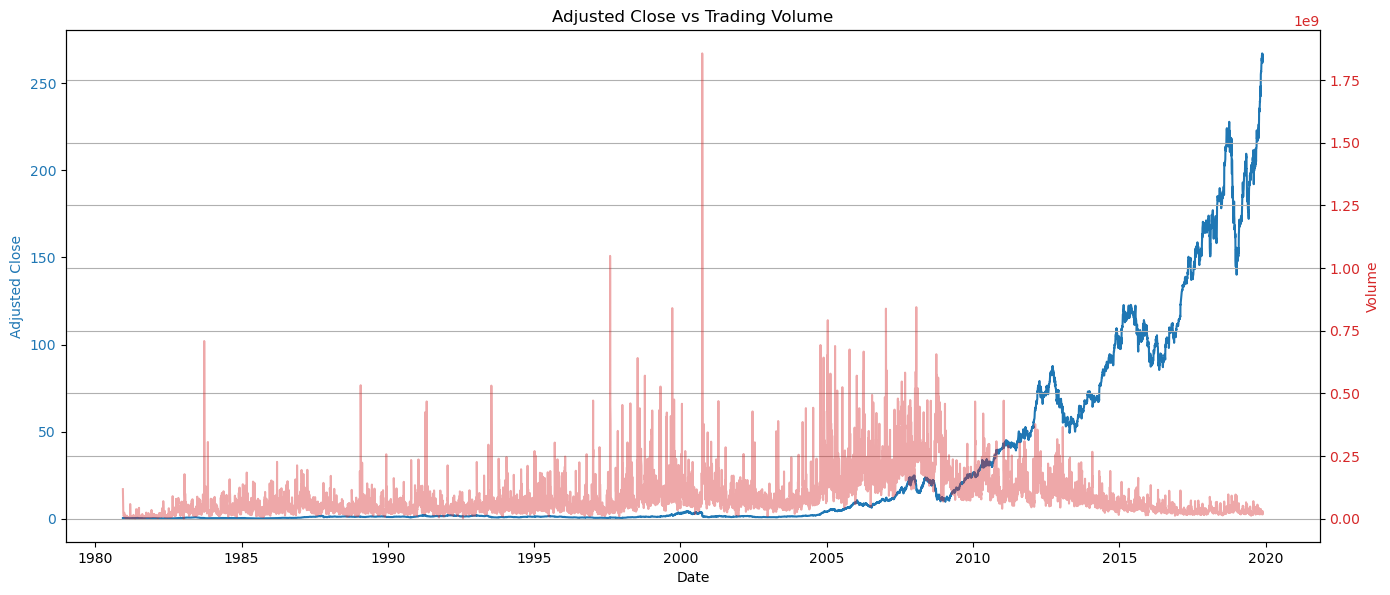

In [15]:
fig, ax1 = plt.subplots(figsize=(14,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close', color='tab:blue')
ax1.plot(df['Adj Close'], color='tab:blue', label='Adj Close')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  # secondary y-axis
ax2.set_ylabel('Volume', color='tab:red')
ax2.plot(df['Volume'], color='tab:red', alpha=0.4, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Adjusted Close vs Trading Volume')
plt.grid(True)
plt.show()

In [27]:
# Step 3: Model deployement

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def build_model(model_type='SimpleRNN', window_size=60, units=50, dropout_rate=0.2):
    model = Sequential()

    # Adding Input layer for Sequential models
    model.add(Input(shape=(window_size, 1)))

    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units=units, return_sequences=False))
    elif model_type == 'LSTM':
        model.add(LSTM(units=units, return_sequences=False))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    
    return model

In [29]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)  # 80% training, 20% testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data to fit LSTM/ RNN input shape (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the model (you can switch between 'SimpleRNN' and 'LSTM')
model = build_model(model_type='LSTM', window_size=60, units=50, dropout_rate=0.2)

# EarlyStopping to stop training if the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

# Save the final model (if needed)
model.save('final_model.keras')

Epoch 1/50
242/245 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.1583e-04

245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.1239e-04 - val_loss: 6.6634e-04
Epoch 2/50
243/245 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2697e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.2687e-05 - val_loss: 4.8877e-04
Epoch 3/50
242/245 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1711e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.1698e-05 - val_loss: 2.6858e-04
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 2.2056e-05 - val_loss: 5.8708e-04
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.8432e-05 - val_loss: 7.1764e-04
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.4847e-05 - val_loss: 4.1464e-04
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.4028e-05 - val_loss: 6.7279e-04
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.4945e-05 - val_loss: 3.9557e-04
Epoch 9/50
242/245 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7357e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.7334e-05 - val_loss: 1.5103e-04
Epoch 10/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.4992e-05 - val_loss: 2.8903e-04
Epoch 11/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.2412e-05 - val_loss: 5.2809e-04
Epoch 12/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6610e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.6603e-05 - val_loss: 1.4442e-04
Epoch 13/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5373e-05 - val_loss: 1.5783e-04
Epoch 14/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.3169e-05 - val_loss: 1.5771e-04
Epoch 15/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.4791e-05 - val_loss: 0.0012
Epoch 16/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5757e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.5752e-05 - val_loss: 1.2041e-04
Epoch 17/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.2285e-05 - val_loss: 1.6928e-04
Epoch 18/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.2546e-05 - val_loss: 3.5509e-04
Epoch 19/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.3354e-05 - val_loss: 2.6216e-04
Epoch 20/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.2434e-05 - val_loss: 1.3292e-04
Epoch 21/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1759e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.1766e-05 - val_loss: 1.1285e-04
Epoch 22/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.3050e-05 - val_loss: 3.4604e-04
Epoch 23/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.1274e-05 - val_loss: 2.1186e-04
Epoch 24/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.4938e-05 - val_loss: 3.6699e-04
Epoch 25/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.2165e-05 - val_loss: 1.3077e-04
Epoch 26/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.2712e-05 - val_loss: 2.8203e-04
Epoch 27/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.2615e-05 - val_loss: 1.1652e-04
Epoch 28/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.1477e-05 - val_loss: 1.2155e-04
Epoch 29/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.2692e-05 - val_loss: 1.9843e-04
Epoch 30/50
243/245 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1543e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.1548e-05 - val_loss: 1.1073e-04
Epoch 31/50
244/245 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1614e-05

245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.1618e-05 - val_loss: 9.6379e-05
Epoch 32/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.4980e-05 - val_loss: 3.0726e-04
Epoch 33/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.2455e-05 - val_loss: 1.0512e-04
Epoch 34/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.2891e-05 - val_loss: 2.4351e-04
Epoch 35/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 1.0644e-05 - val_loss: 2.8843e-04
Epoch 36/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.3973e-05 - val_loss: 2.7805e-04
Epoch 37/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.3931e-05 - val_loss: 1.0843e-04
Epoch 38/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.1226e-05 - val_loss: 1.6041e-04
Epoch 39/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 1.3863e-05 - val_loss: 1.6998e-04
Epoch 40/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.3067e-05 - val_loss: 1.2333e-04
Epoch 41/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/ste

C:\Users\ratnakar\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1668e-05
Test Loss (MSE): 9.637880430091172e-05
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


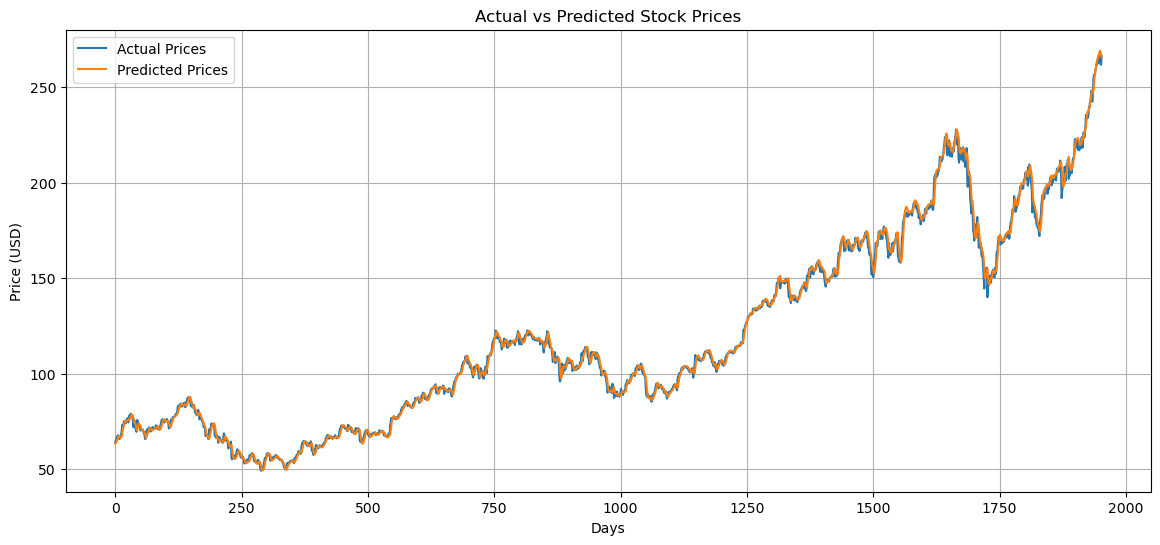

In [31]:
# Load the best model (if not already loaded)
best_model = tf.keras.models.load_model('final_model.keras')

# Evaluate the model on the test set
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")

# Predict stock prices on the test data
predictions = best_model.predict(X_test)

# Inverse transform the predictions and true values (to get original scale)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predictions vs actual values
plt.figure(figsize=(14,6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error: 6.8679


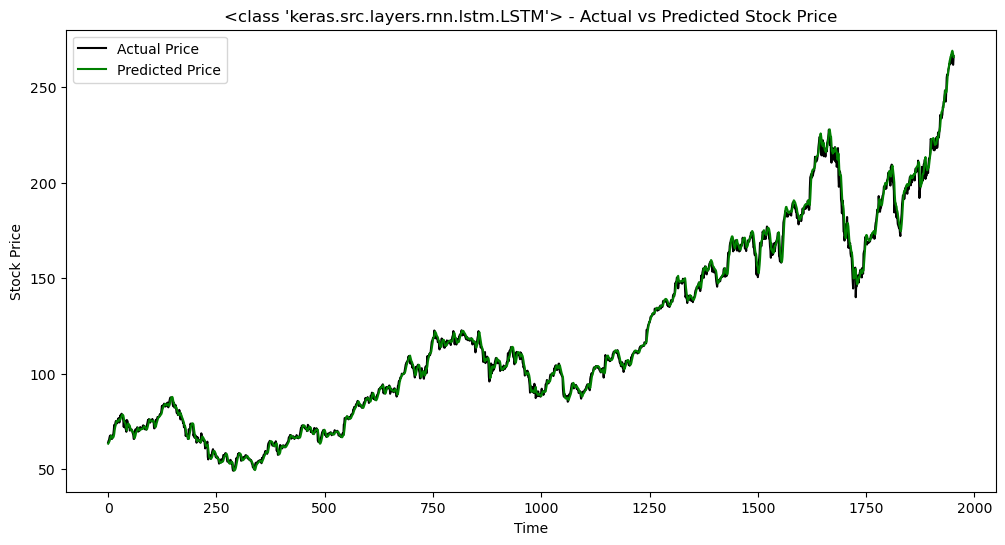

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Predict on test data
predictions = model.predict(X_test)

# Inverse scale the predictions and actual values
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
mse = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error: {mse:.4f}")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='black')
plt.plot(predicted_prices, label='Predicted Price', color='green')
plt.title(f'{LSTM} - Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [37]:
# Comparing both models 
# Train SimpleRNN
rnn_model = build_model(model_type='SimpleRNN')
rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1,
              callbacks=[EarlyStopping(patience=5), ModelCheckpoint('best_rnn.keras', save_best_only=True)])

# Train LSTM
lstm_model = build_model(model_type='LSTM')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1,
               callbacks=[EarlyStopping(patience=5), ModelCheckpoint('best_lstm.keras', save_best_only=True)])

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3543e-04 - val_loss: 3.7363e-05
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0658e-06 - val_loss: 1.7848e-05
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2183e-06 - val_loss: 2.3419e-05
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.5271e-06 - val_loss: 3.4180e-05
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0581e-06 - val_loss: 4.8453e-05
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6699e-06 - val_loss: 9.4991e-06
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2399e-06 - val_loss: 1.1884e-05
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8666e-06 - val_loss: 2.8890e-05
Epoch 9/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9459e-06 - val_loss: 1.6599e-05
Epoch 10/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0492e-06 - val_loss: 9.2679e-06
Epoch 11/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss

In [39]:
from sklearn.metrics import mean_squared_error

# Load best models
best_rnn = tf.keras.models.load_model('best_rnn.keras')
best_lstm = tf.keras.models.load_model('best_lstm.keras')

# Predict
rnn_preds = best_rnn.predict(X_test)
lstm_preds = best_lstm.predict(X_test)

# Inverse transform
rnn_preds_inv = scaler.inverse_transform(rnn_preds)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE
rnn_mse = mean_squared_error(y_test_inv, rnn_preds_inv)
lstm_mse = mean_squared_error(y_test_inv, lstm_preds_inv)

print(f"SimpleRNN MSE: {rnn_mse:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
SimpleRNN MSE: 8.8241
LSTM MSE: 21.8496


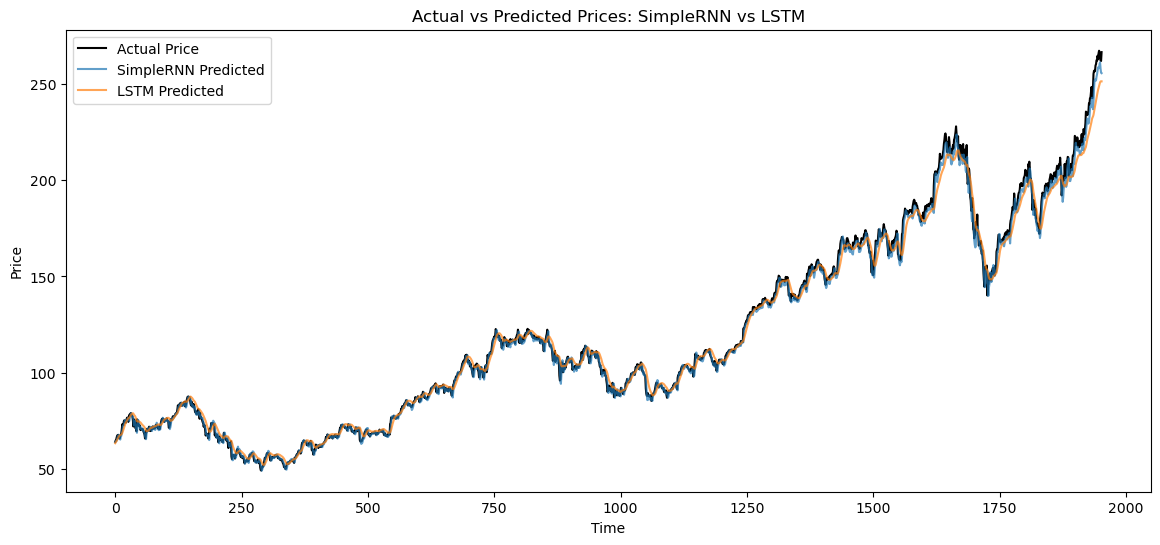

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Actual Price', color='black')
plt.plot(rnn_preds_inv, label='SimpleRNN Predicted', alpha=0.7)
plt.plot(lstm_preds_inv, label='LSTM Predicted', alpha=0.7)
plt.title('Actual vs Predicted Prices: SimpleRNN vs LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
import pandas as pd

comparison = pd.DataFrame({
    'Model': ['SimpleRNN', 'LSTM'],
    'MSE': [rnn_mse, lstm_mse]
})
print(comparison)

       Model        MSE
0  SimpleRNN   8.824135
1       LSTM  21.849582
